In [1]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver")

In [2]:
from ccode.gates_trijunction import gates_trijunction
import numpy as np
import matplotlib.pyplot as plt
from ccode.potential import gate_potential, linear_problem_instance
from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian
from scipy import constants
from utility import prepare_voltages
from plotting import plot_potential
import kwant
import scipy.sparse.linalg as sla
import ccode.tools as tl
import ccode.finite_system as tj
import tinyarray as ta
import scipy.sparse.linalg as sla
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [604]:
constants.electron_mass

9.1093837015e-31

In [605]:
constants.m_e

9.1093837015e-31

In [124]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Electrostatic potential

In [575]:
thickness_GaAs = 10
thickness_twoDEG = 10
thickness_Al2O3 = 10
thickness_gate = 10
thickness_self_Al2O3 = 0.5

meff = 0.023 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 12.9
permittivity_air = 1.0

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG

density = 1.9e11  # Electron density in 2DEG per cm2
cm = 1.0
m = 1e2 * cm
density_m2 = density * m ** 2  # Electron density in 2DEG per m2
#scaling_eV = 1 / (constants.e)  # in eV
#mu = (((constants.hbar ** 2) * np.pi * density_m2) / meff) * scaling_eV

In [169]:
area = 700
angle = np.pi/3
wire_width = 7
gap = 4

In [170]:
triangle_length = np.sqrt(area*np.tan(angle))
triangle_width = np.abs((triangle_length/np.tan(angle)))
top_shift = np.tan(angle)*(wire_width/2)
tunnel_length = wire_width
tunnel_width = wire_width

total_length = triangle_length + 2 * tunnel_length + 2 * gap - top_shift
extra_width = 3
total_width = 2 * extra_width + triangle_width
total_width = 2*total_width

In [171]:
gates = gates_trijunction(area, angle, wire_width, gap, extra_width)

In [172]:
zmin = -0.5
zmax = 0.5
xmax = triangle_width
xmin = -xmax
ymin = 0
ymax = total_length
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]

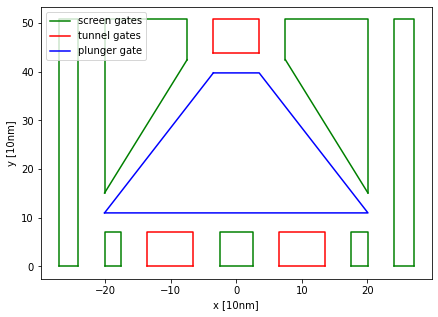

In [173]:
fig, ax = plt.subplots(figsize=(7, 5))

for _, gate in gates["screening_gates"].items():
    ax.plot(gate[:, 0], gate[:, 1], "g", label='screen gates')
    ax.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "g", label='screen gates')
    
for _, gate in gates["tunnel_gates"].items():
    ax.plot(gate[:, 0], gate[:, 1], "r", label='tunnel gates')
    ax.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "r", label='tunnel gates')

for _, gate in gates["back_gates"].items():
    ax.plot(gate[:, 0], gate[:, 1], "b", label='plunger gate')
    ax.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "b", label='plunger gate')

ax.set_ylabel('y [10nm]')
ax.set_xlabel('x [10nm]')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

In [174]:
layout = Layout(
    total_width, total_length, grid_width_air=grid_spacing_air, margin=(50, 50, 50), shift=(0, total_length/2, 0)
)

In [175]:
layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG
    ),
    center=True,
)

layout.add_layer(
    SimpleChargeLayer(
        "GaAs",
        thickness_GaAs,
        permittivity_GaAs,
        grid_spacing_GaAs,
    )
)

In [176]:
vertex = (
    list(gates["back_gates"].values()),
    list(gates["screening_gates"].values()),
    list(gates["tunnel_gates"].values()),
        )

layout.add_layer(
    OverlappingGateLayer(
        vertex,
        np.hstack([list(gates[key].keys()) for key, _ in gates.items()]),
        thickness_gate,
        thickness_self_Al2O3,
        permittivity_metal,
        grid_spacing_gate,
    )
)

In [177]:
%%time
poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 42.8 s, sys: 2.21 s, total: 45.1 s
Wall time: 45 s


In [178]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('mixed', 'twoDEG')], boundaries=boundaries
)

In [634]:
# %%px --local

model = "A0 * (k_x**2 + k_y**2) + V(x, y)"

A0 = (constants.hbar) ** 2 / (2 * meff * constants.e * (1e-9) ** 2)


def onsite(site, A0, V):
    (x, y,) = site.pos
    _const_0 = V(x, y)
    return (4 / (grid_spacing) ** 2) * A0 + _const_0


def hopping(site1, site2, A0):
    return -(1 / (grid_spacing) ** 2) * A0


grid_spacing = grid_spacing_twoDEG
kwant_syst = kwant_system(site_coords[:, [0, 1]], onsite, hopping, grid_spacing)
kwant_sites = np.array([site.pos for site in kwant_syst.sites])

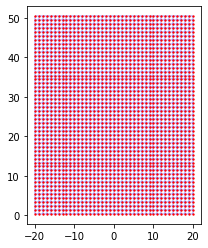

In [635]:
kwant.plot(kwant_syst, site_size=0.3, site_color='r', hop_color='b',);

In [636]:
# parameters for trijunction builder
a = 1
L = boundaries[3] - boundaries[2]
W = boundaries[1] - boundaries[0]
crds = site_coords[:, [0, 1]]
offset = crds[0]%grid_spacing

In [715]:
# voltages
depleted = -3
voltages = {'back_gate': -depleted,
  'left_triangle_screen_gate': depleted,
  'right_triangle_screen_gate': depleted,
  'bot_central_screen_gate': 2*depleted,
  'bot_left_screen_gate': depleted,
  'bot_right_screen_gate': depleted,
  'left_screen_gate': 2*depleted,
  'right_screen_gate': 2*depleted,
  'top_tunnel_gate': -depleted,
  'left_tunnel_gate': -depleted,
  'right_tunnel_gate': depleted}

volt = list(voltages.values())
gates = list(voltages.keys())
voltages = prepare_voltages(volt, gates)
charges = {}

electrons = 1.0  # We consider electrons

sign_potential_energy = -1.0 if electrons else 1.0

In [716]:
clean_potential = gate_potential(
    poisson_system,
    linear_problem,
    site_coords[:, [0, 1]],
    site_indices,
    voltages,
    charges,
    offset
)

In [717]:
clean_potential.update(
    (key, sign_potential_energy * value) for key, value in clean_potential.items()
)


def get_potential(x, y):
    return clean_potential[ta.array([x, y])]

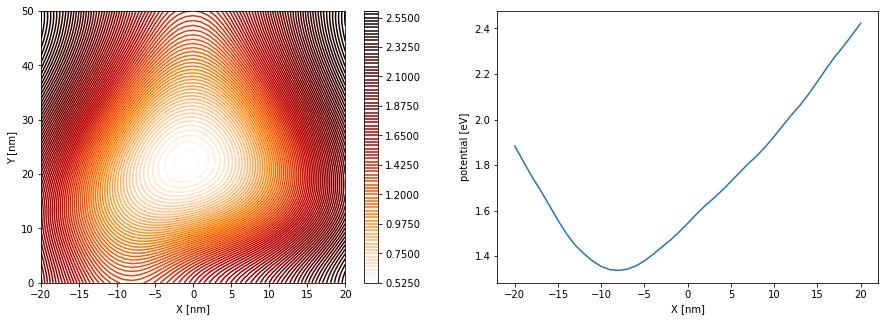

In [718]:
plot_potential([clean_potential], [0.0])

In [719]:
clean_potential = gate_potential(
    poisson_system,
    linear_problem,
    site_coords[:, [0, 1]],
    site_indices,
    voltages,
    charges,
    offset=np.array([0, 0])
)

In [720]:
def get_potential_wrap(i):
    x, y = kwant_syst.sites[i].pos
    return get_potential(x, y)

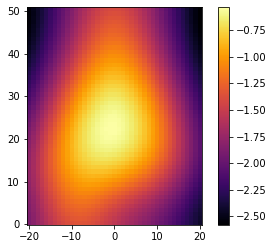

In [721]:
kwant.plotter.map(kwant_syst, get_potential_wrap, cmap='inferno');

In [722]:
params = dict(A0=A0, V=get_potential)
n = 20
ham_mat = kwant_syst.hamiltonian_submatrix(params=params, sparse=True)
evals, evecs = tl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, which='LA'))
evals

array([11.83202907, 11.86738912, 11.88351684, 11.8923727 , 11.92842451,
       11.92985202, 11.9761174 , 11.98377035, 12.03169401, 12.05340912,
       12.08757872, 12.0938395 , 12.14313491, 12.19716931, 12.21892535,
       12.26246051, 12.31294935, 12.38865587, 12.4347782 , 12.56234418])

In [723]:
density = kwant.operator.Density(kwant_syst, np.eye(1))

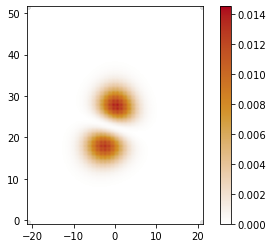

In [724]:
kwant.plotter.density(kwant_syst, density(evecs[-2]));

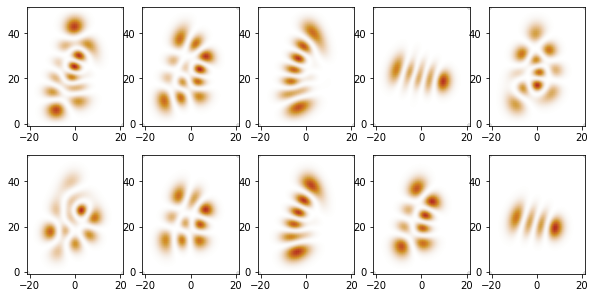

In [725]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
i = 0
for ax in axes.flatten():
    kwant.plotter.density(kwant_syst, density(evecs[i]), ax=ax);
    i += 1

## Trijunction

In [726]:
params = tl.finite_coupling_parameters(index=0)[0]
params.update(mus_nw=np.array([-2, -2, -2]))
params.update(B_x=0)
params.update(alpha=0)
a = params['a']
t = params['t']
params.update(t=100*t)

In [727]:
geometry = {
"l": 1*a,
"w": 7*a,
"a": a,
"side": 'up',
"shape": 'rectangle',
"L": L*a,
"W": W*a,
"center": W*a/4
}

In [728]:
trijunction, f_params, f_params_potential = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


(-1e-07, 6.075786762577987e-07)

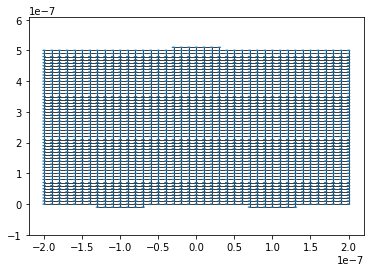

In [729]:
off = 0.1e-6
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax);
ax.set_ylim(-off, L*a+off)

In [730]:
a

1e-08

In [731]:
clean_potential = gate_potential(
    poisson_system,
    linear_problem,
    site_coords[:, [0, 1]],
    site_indices,
    voltages,
    charges,
    offset,
    grid_spacing=a
)

In [732]:
def get_potential(x, y):
    return clean_potential[ta.array([x, y])]

In [733]:
f_mu = f_params_potential(potential=get_potential, params=params)['mu']

In [734]:
def f_mu_wrap(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

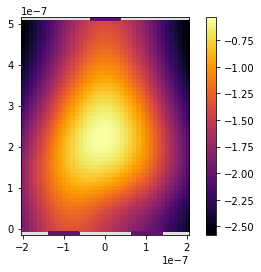

In [735]:
kwant.plotter.map(trijunction, f_mu_wrap, cmap='inferno', colorbar=True);

In [736]:
n = 40
ham_mat = trijunction.hamiltonian_submatrix(sparse=True, 
                                            params=f_params_potential(potential=get_potential, params=params))
ham_mat

<8448x8448 sparse matrix of type '<class 'numpy.complex128'>'
	with 41564 stored elements in COOrdinate format>

In [737]:
evals, evecs = tl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))
evals

array([-1.16443803, -1.16443803, -1.15819895, -1.15819895, -1.10890803,
       -1.10890803, -1.05488097, -1.05488097, -1.03312736, -1.03312736,
       -0.98959756, -0.98959756, -0.93911549, -0.93911549, -0.86341675,
       -0.86341675, -0.81730026, -0.81730026, -0.6897491 , -0.6897491 ,
        0.6897491 ,  0.6897491 ,  0.81730026,  0.81730026,  0.86341675,
        0.86341675,  0.93911549,  0.93911549,  0.98959756,  0.98959756,
        1.03312736,  1.03312736,  1.05488097,  1.05488097,  1.10890803,
        1.10890803,  1.15819895,  1.15819895,  1.16443803,  1.16443803])

In [738]:
density = kwant.operator.Density(trijunction, np.eye(4))

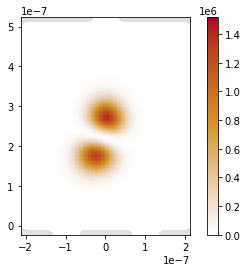

In [739]:
kwant.plotter.density(trijunction, density(evecs[16]));

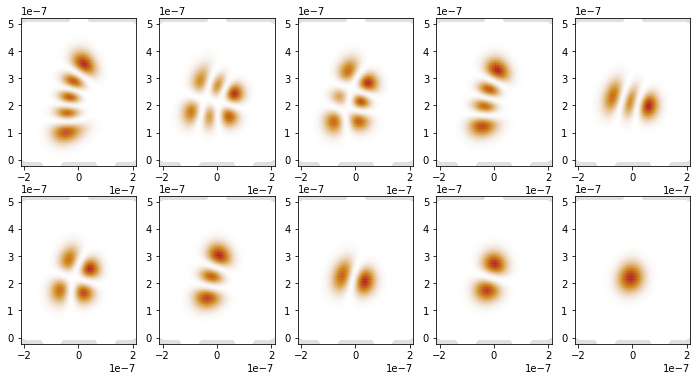

In [742]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
i = 0
for ax in axes.flatten():
    kwant.plotter.density(trijunction, density(evecs[2*i]), ax=ax);
    i += 1

In [745]:
def potentials(voltages, vs, key):
    potentials = dict()
    for v in vs:
        voltages.update(key=v)
        volt = list(voltages.values())
        gates = list(voltages.keys())
        voltages_config = prepare_voltages(volt, gates)
        clean_potential = gate_potential(
            poisson_system,
            linear_problem,
            site_coords[:, [0, 1]],
            site_indices,
            voltages_config,
            charges,
            offset,
            grid_spacing=a
        )
        potentials.update(v=clean_potential)
    return potentials